In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
from qiskit import QuantumRegister, ClassicalRegister

In [3]:
import numpy as np
import pandas as pd

In [4]:
import matplotlib.pyplot as plt

In [5]:
# Hamiltonian
H = np.mat("1 0 0 0; 0 0 -1 0; 0 -1 0 0; 0 0 0 1")
H

matrix([[ 1,  0,  0,  0],
        [ 0,  0, -1,  0],
        [ 0, -1,  0,  0],
        [ 0,  0,  0,  1]])

In [6]:
# Pauli matrices
mat_pauli_x = np.mat("0 1; 1 0")
mat_pauli_y = np.mat("0 -1j; 1j, 0")
mat_pauli_z = np.mat("1 0; 0 -1")
# Identity matrix
mat_id = np.mat("1 0; 0 1")

In [7]:
# I⊗I
s_ii = np.kron(mat_id, mat_id)
# X⊗X
s_xx = np.kron(mat_pauli_x, mat_pauli_x)
# Y⊗Y
s_yy = np.real(np.kron(mat_pauli_y, mat_pauli_y))
# Z⊗Z
s_zz = np.kron(mat_pauli_z, mat_pauli_z)

In [8]:
# Getting the coefficients of the Pauli matrices
s_alpha = np.dot(s_ii.conjugate().transpose(), H).trace() / 4
s_beta = np.dot(s_xx.conjugate().transpose(), H).trace() / 4
s_gamma = np.dot(s_yy.conjugate().transpose(), H).trace() / 4
s_delta = np.dot(s_zz.conjugate().transpose(), H).trace() / 4

In [9]:
H_p = (
    s_alpha.A1[0] * s_ii
    + s_beta.A1[0] * s_xx
    + s_gamma.A1[0] * s_yy
    + s_delta.A1[0] * s_zz
)
H_p

matrix([[ 1.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  0.],
        [ 0., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  1.]])

In [10]:
# Coefficients of the Hamiltonian expressed in Pauli terms
lst_h_coef = dict(II= s_alpha.A1[0], XX= s_beta.A1[0], YY= s_gamma.A1[0], ZZ=s_delta.A1[0])
# lst_h_coef = [s_alpha.A1[0], s_beta.A1[0], s_gamma.A1[0], s_delta.A1[0]]
lst_h_coef

{'II': 0.5, 'XX': -0.5, 'YY': -0.5, 'ZZ': 0.5}

In [11]:
# Define variational parameter for RX
lst_angles = list(np.linspace(0, 2 * np.pi, 360))

In [12]:
## Registers
reg_Quantum = QuantumRegister(2)
reg_Classic = ClassicalRegister(2)

In [13]:
# Define simulator
simulator = Aer.get_backend("statevector_simulator")
# Number of shots
int_shots = 1024

In [14]:
def f_create_circuits(
    arg_angle, arg_QuantRegs=reg_Quantum, arg_ClassRegs=reg_Classic, arg_ncircuits=3
):
    # List of circuits
    lst_circuits = [
        QuantumCircuit(arg_QuantRegs, arg_ClassRegs) for _ in range(arg_ncircuits)
    ]
    
    # Set register
    lst_regs = [x.qregs[0] for x in lst_circuits]
    # Defining circuits
    # XX, YY, ZZ
    [lst_circuits[i].rx(arg_angle, j[0]) for i,j in zip(range(arg_ncircuits), lst_regs)]
    [lst_circuits[i].rx(arg_angle, j[1]) for i,j in zip(range(arg_ncircuits), lst_regs)]
    
    # XX
    lst_circuits[0].u2(0, np.pi, reg_Quantum[0])
    lst_circuits[0].measure(arg_QuantRegs[0], arg_ClassRegs[0])
    lst_circuits[0].u2(0, np.pi, reg_Quantum[1])
    lst_circuits[0].measure(arg_QuantRegs[1], arg_ClassRegs[1])
    # YY
    lst_circuits[1].u2(0, np.pi/2, reg_Quantum[0])
    lst_circuits[1].measure(arg_QuantRegs[0], arg_ClassRegs[0])
    lst_circuits[1].u2(0, np.pi/2, reg_Quantum[1])
    lst_circuits[1].measure(arg_QuantRegs[1], arg_ClassRegs[0])
    
    # Measure ZZ
    lst_circuits[2].measure(arg_QuantRegs[0], arg_ClassRegs[0])
    lst_circuits[2].measure(arg_QuantRegs[1], arg_ClassRegs[1])

    # Return
    return lst_circuits

In [15]:
def f_circuit_counts(arg_lst_ckts, arg_backend=simulator, arg_shots=int_shots):
    #
    lst_jobs = [execute(x, backend=arg_backend, shots=arg_shots) for x in arg_lst_ckts]
    #
    lst_results = [x.result() for x in lst_jobs]
    #
    lst_counts = [x.get_counts() for x in lst_results]
    #
    lst_eval = [sum([-val if key in ["01", "10"] else val for key,val in x.items()]) for x in lst_counts]
    #
    return lst_eval

In [16]:
def f_expH(arg_lst_counts, arg_lst_coef=lst_h_coef):
    # II
    arg_lst_counts.insert(0, 1)
    #
    lst_exp = [x*y for x,y in zip(arg_lst_counts, arg_lst_coef.values())]
    #
    return sum(lst_exp)

In [17]:
#
lst_exp_H = []
#
for angle in lst_angles:
    #
    lst_ckts = f_create_circuits(angle)
    #
    lst_exp_H.append([angle, f_expH(f_circuit_counts(lst_ckts))])

In [18]:
df_meas=pd.DataFrame(lst_exp_H, columns=["angle", "E_x"])

In [19]:
print("The lowest eigenvalue is {}".format(min(df_meas["E_x"]))) 

The lowest eigenvalue is -1.0


In [20]:
df_meas.sort_values(by=["angle"], inplace=True)

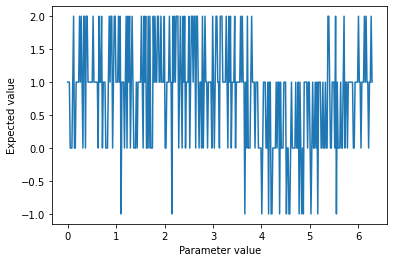

In [21]:
plt.xlabel("Parameter value")
plt.ylabel("Expected value")
plt.plot(df_meas["angle"], df_meas["E_x"])
plt.show()